# Chess Policy Model Comparison: CNN vs Transformer

## Dataset: Lichess Puzzles

This notebook analyzes predictions from two chess policy models (CNN and Transformer) on a Lichess puzzles dataset.

**Dataset columns:**
- `PuzzleId`: Unique puzzle identifier
- `FEN`: Chess position in Forsyth-Edwards Notation
- `Moves`: Ground truth solution moves (first move is the target)
- `Rating`: Puzzle difficulty rating
- `RatingDeviation`: Uncertainty measure for the rating
- `Popularity`: Puzzle popularity score
- `NbPlays`: Number of times the puzzle has been played
- `Themes`: Puzzle themes/categories
- `GameUrl`: URL to the original game
- `OpeningTags`: Chess opening classification tags
- `cnn_predicted_move`: Top-1 predicted move from CNN model (UCI format)
- `transformer_predicted_move`: Top-1 predicted move from Transformer model (UCI format)
- `cnn_top5_moves`: Top-5 predicted moves from CNN model (UCI format, string list)
- `transformer_top5_moves`: Top-5 predicted moves from Transformer model (UCI format, string list)
- `cnn_correct`: Boolean indicating if CNN's top-1 prediction is correct
- `transformer_correct`: Boolean indicating if Transformer's top-1 prediction is correct

## The Unexpected Claim (Paradox)

Aggregate Top-1 accuracy suggests CNN and Transformer have the same performance, despite Transformer being expected to perform better. This notebook investigates the causes of this apparent paradox using causal analysis and data-driven methods.

## Section 1: Setup and Load

In this section, we set up the analysis environment by importing necessary libraries and loading the dataset. We perform initial data inspection to understand the structure, data types, and basic characteristics of the dataset before proceeding with the analysis.

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json

In [139]:
# Section 1: Setup and Load
# Load CSV from Data/results_full.csv
raw_df = pd.read_csv('Data/results_full.csv')

In [140]:
df = raw_df.copy()

In [141]:
# Display basic data information
print("DATASET OVERVIEW:")
print(f"\nShape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Display column types and non-null counts
print(df.info())

# TODO: Load CSV from Data/results_full.csv
# - Use pandas read_csv()
# - Store in variable: df
print("FIRST 5 ROWS:")
display(df.head())  # Use display() for better Jupyter rendering

DATASET OVERVIEW:

Shape: 5,600,086 rows × 16 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600086 entries, 0 to 5600085
Data columns (total 16 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   PuzzleId                    object
 1   FEN                         object
 2   Moves                       object
 3   Rating                      int64 
 4   RatingDeviation             int64 
 5   Popularity                  int64 
 6   NbPlays                     int64 
 7   Themes                      object
 8   GameUrl                     object
 9   OpeningTags                 object
 10  cnn_predicted_move          object
 11  transformer_predicted_move  object
 12  cnn_top5_moves              object
 13  transformer_top5_moves      object
 14  cnn_correct                 int64 
 15  transformer_correct         int64 
dtypes: int64(6), object(10)
memory usage: 683.6+ MB
None
FIRST 5 ROWS:


,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,cnn_predicted_move,transformer_predicted_move,cnn_top5_moves,transformer_top5_moves,cnn_correct,transformer_correct
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - - 0 24,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1877,76,95,8786,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,NaN,b2b1,b2b1,"[""b2b1"", ""f2g3"", ""e7e6"", ""b2a3"", ""b2c2""]","[""b2b1"", ""f2g3"", ""b2c2"", ""e7e6"", ""b2a1""]",0,0
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - - 2 27,d3d6 f8d8 d6d8 f6d8,1501,73,96,35000,advantage endgame short,https://lichess.org/F8M8OS71#53,NaN,d3d6,d3d6,"[""d3d6"", ""d3d7"", ""d3c4"", ""h2h4"", ""h2h3""]","[""d3d6"", ""h2h3"", ""g2g3"", ""d3d2"", ""d3d4""]",1,1
2,0008Q,8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64,e7f7 f5e5 e2f1 e5e6,1355,76,91,743,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#127,NaN,e7g7,e7g7,"[""e7g7"", ""e7h7"", ""e7f7"", ""e7e8"", ""e7b7""]","[""e7g7"", ""e7h7"", ""e7f7"", ""e7e8"", ""e7b7""]",0,0
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP1P/RN1QR1K1 b - - 1 16,b6c5 e2g4 h3g4 d1g4,1103,74,88,603,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Variation,d8g5,d8d4,"[""d8g5"", ""d8f6"", ""d8d7"", ""b6b5"", ""g4f6""]","[""d8d4"", ""d8f6"", ""g4f2"", ""g4f6"", ""d8g5""]",0,0
4,000Pw,6k1/5p1p/4p3/4q3/3nN3/2Q3P1/PP3P1P/6K1 w - - 2 37,e4d2 d4e2 g1f1 e2c3,1422,74,92,604,crushing endgame fork short,https://lichess.org/au2lCK5o#73,NaN,c3c8,c3e3,"[""c3c8"", ""c3e3"", ""c3d3"", ""c3d4"", ""c3c5""]","[""c3e3"", ""c3d3"", ""c3c8"", ""c3d2"", ""c3f3""]",0,0


## Section 2: Reproduce the Paradox

This section demonstrates the unexpected finding: aggregate Top-1 accuracy suggests CNN performs as well as or better than Transformer, despite expectations that Transformer should outperform CNN. In head-to-head games, the Transformer achieved ~48% win rate versus ~30% for the CNN, so the aggregate Top-1 result is counterintuitive. We extract ground truth moves, parse model predictions, compute accuracies, and visualize the paradox with a comparison plot.

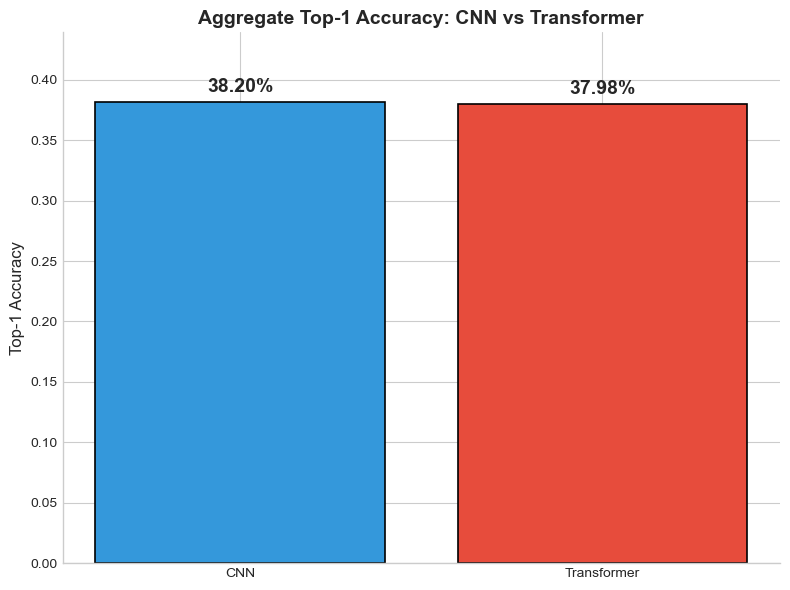

CNN Top-1 Accuracy: 0.3820
Transformer Top-1 Accuracy: 0.3798

Paradox: CNN >= Transformer in aggregate (or ties)


In [142]:
# Section 2: Reproduce the Paradox
#ask about the preprocessing for the data (lke extracting the ground truth move)

# Compute Top-1 accuracy for CNN and Transformer
cnn_top1_acc = df['cnn_correct'].mean()
tr_top1_acc = df['transformer_correct'].mean()


# Create comparison bar plot showing aggregate accuracies
fig, ax = plt.subplots(figsize=(8, 6))

models = ['CNN', 'Transformer']
accuracies = [cnn_top1_acc, tr_top1_acc]
colors = ['#3498db', '#e74c3c']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{acc:.2%}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
ax.set_ylabel('Top-1 Accuracy', fontsize=12)
ax.set_title('Aggregate Top-1 Accuracy: CNN vs Transformer', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(accuracies) * 1.15)  # Add space for labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#Display the paradox
print(f"CNN Top-1 Accuracy: {cnn_top1_acc:.4f}")
print(f"Transformer Top-1 Accuracy: {tr_top1_acc:.4f}")
print("\nParadox: CNN >= Transformer in aggregate (or ties)")


## Section 3: Data Cleaning and Filling

In [143]:
#check for missing values
for col in df.columns:
    missing_values = df[col].isnull().sum()
    if missing_values > 0:
        print(f"Column '{col}' has {missing_values} missing values.")


Column 'OpeningTags' has 4471771 missing values.


In [144]:
#Handle missing values in critical columns, after inspecting the data we relised taht missing values 
# in this column indicate a later step in the game, making it its own category
df['OpeningTags'] = df['OpeningTags'].fillna('unknown_opening')



# Check for duplicate PuzzleId values
dup_mask = df['PuzzleId'].duplicated(keep=False) 
n_dup_rows = dup_mask.sum()
n_dup_ids = df.loc[dup_mask, 'PuzzleId'].nunique()

print(f"Rows with duplicated PuzzleId: {n_dup_rows:,}")
print(f"Unique PuzzleId values that are duplicated: {n_dup_ids:,}")

if n_dup_ids == 0:
    print("No duplicate PuzzleId values found.")


Rows with duplicated PuzzleId: 0
Unique PuzzleId values that are duplicated: 0
No duplicate PuzzleId values found.


## Section 3.2: Boxplots and Outlier Handling (Rating, RatingDeviation, Popularity, NbPlays)

We visualize the distributions of key numeric dataset fields using boxplots to detect extreme values (outliers). Then we decide a consistent outlier-handling rule (e.g., IQR-based filtering or winsorization) so later analyses (binning, conditioning, KL) aren't dominated by extreme values.

Summary statistics (including log_NbPlays):


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Rating,5600086.0,1483.663988,546.514349,399.0,462.000000,663.000000,1054.000000,1435.000000,1890.000000,2438.00000,2727.000000,3395.000000
RatingDeviation,5600086.0,87.110992,27.581030,45.0,74.000000,74.000000,76.000000,78.000000,88.000000,119.00000,209.000000,500.000000
Popularity,5600086.0,86.152684,14.267439,-83.0,25.000000,58.000000,83.000000,90.000000,94.000000,100.00000,100.000000,100.000000
log_NbPlays,5600086.0,5.929779,1.736260,0.0,2.197225,3.218876,4.682131,5.860786,7.108244,9.01469,9.953753,12.652536


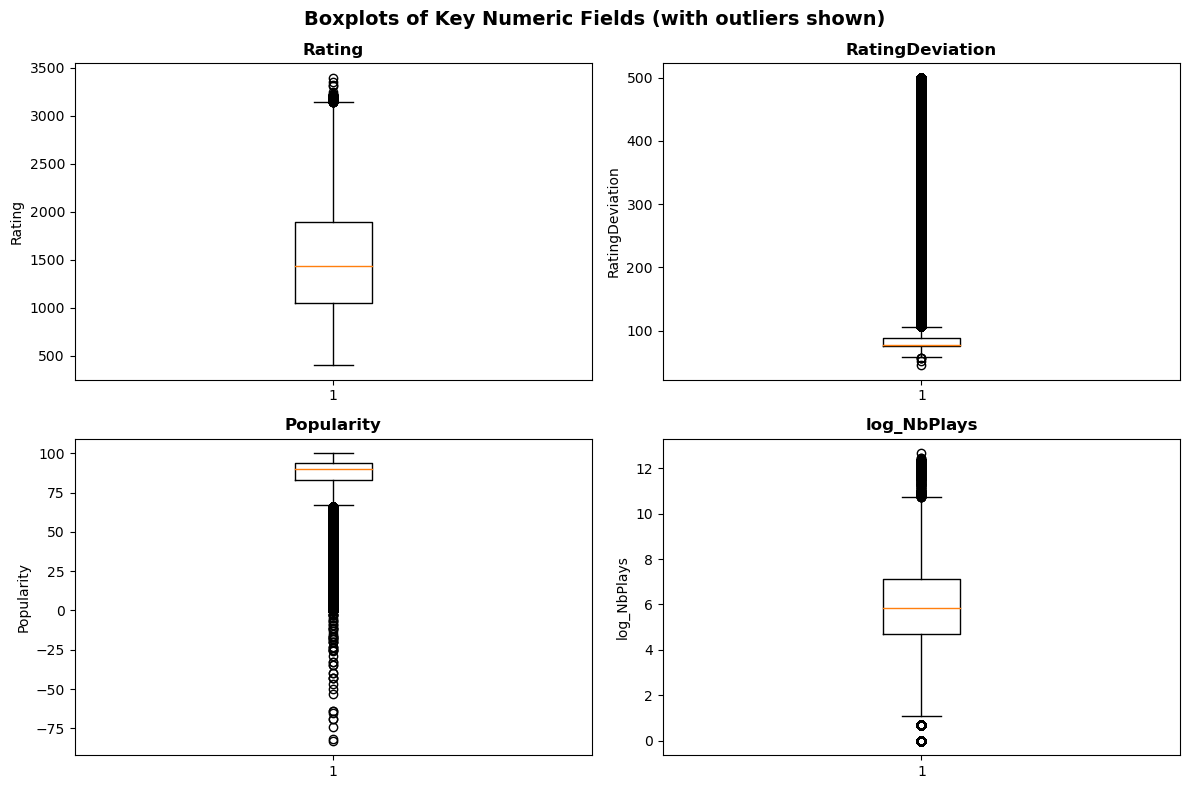

OUTLIER SUMMARY (IQR rule)


,Column,Lower Bound,Upper Bound,N Outliers,% Outliers
0,Rating,-200.000000,3144.000000,82,0.00
1,RatingDeviation,58.000000,106.000000,484632,8.65
2,Popularity,66.500000,110.500000,398478,7.12
3,log_NbPlays,1.042962,10.747414,6546,0.12


OUTLIER SUMMARY (Z-score |z|>3)


,Column,N Outliers,% Outliers
0,Rating,125,0.00
1,RatingDeviation,104644,1.87
2,Popularity,137529,2.46
3,log_NbPlays,6467,0.12


Flag rates:


,flag_unreliable_rate,flag_low_pop_rate,rd_q95,plays_q05,pop_q05
0,0.065261,0.050117,119.0,24.0,58.0


Baseline N=5,600,086; Filtered (reliable-only) N=5,234,621 (93.5% kept)


In [8]:
# Section 3.2: Boxplots and Outlier Handling

cols = ['Rating', 'RatingDeviation', 'Popularity', 'NbPlays']

# --- 1) Basic sanity checks ---
print("Summary statistics for numeric columns:")
display(df[cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

# --- 2) Boxplots (one per metric) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    x = df[col].dropna().values
    ax.boxplot(x, vert=True, showfliers=True)
    ax.set_title(col, fontsize=12, fontweight='bold')
    ax.set_ylabel(col)

plt.suptitle("Boxplots of Key Numeric Fields (with outliers shown)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- 3) Outlier detection (IQR rule) ---
print("\n" + "=" * 60)
print("OUTLIER DETECTION (IQR Rule: Q1 - 1.5*IQR, Q3 + 1.5*IQR)")
print("=" * 60)

outlier_summary = []
bounds = {}

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    bounds[col] = (lower, upper)

    mask_out = (df[col] < lower) | (df[col] > upper)
    outlier_summary.append({
        'Column': col,
        'Lower Bound': lower,
        'Upper Bound': upper,
        'N Outliers': int(mask_out.sum()),
        '% Outliers': round(mask_out.mean() * 100, 2),
    })

outlier_summary_df = pd.DataFrame(outlier_summary)
display(outlier_summary_df)

# --- 4) Handle outliers (choose ONE method) ---
# Option A: Filtering (drop rows that are outliers in ANY of these columns)
# outlier_any = np.zeros(len(df), dtype=bool)
# for col, (lower, upper) in bounds.items():
#     outlier_any |= (df[col] < lower) | (df[col] > upper)
# df_clean = df.loc[~outlier_any].copy()
# print(f"Dropped {outlier_any.sum():,} rows ({outlier_any.mean()*100:.2f}%) due to outliers across {cols}")

# Option B: Winsorization (clip values to IQR bounds; keeps all rows)
# df_clean = df.copy()
# for col, (lower, upper) in bounds.items():
#     df_clean[col] = df_clean[col].clip(lower=lower, upper=upper)
# print("Applied winsorization (clipping) to outliers using IQR bounds.")

# TODO: Decide whether to use df_clean going forward, or keep df unchanged.

## Section 4: Causal Framing - Directed Acyclic Graph (DAG)

Before diving into exploratory analysis, we frame the problem using causal reasoning. The apparent paradox may be explained by confounding variables that affect both model performance and the distribution of puzzles in the dataset.

### Causal DAG

```
         Model Type
              |
              v
      Prediction Accuracy
              ^
         /    |    \
        /     |     \
    Rating  Themes  [other confounders]
       |       |
       +-------+ (potential relationship)
```

**Key relationships:**

1. **Model Type → Prediction Accuracy**: The choice of model (CNN vs Transformer) directly affects prediction accuracy. However, this relationship may be obscured by confounders.

2. **Rating → Accuracy**: Puzzle difficulty (rating) affects how well models perform. Harder puzzles (higher ratings) may be more challenging for both models, but the effect may differ.

3. **Themes → Accuracy**: Different puzzle themes (e.g., "mateIn2", "defensiveMove") may have varying difficulty levels or require different types of reasoning, affecting model performance.

4. **Rating ↔ Themes**: There may be relationships between puzzle difficulty and theme distribution (certain themes may be more common at specific rating ranges).

### Justification for Conditioning

To identify the true causal effect of Model Type on Accuracy, we must condition on confounders (Rating, Themes). This is the essence of Simpson's paradox: aggregate comparisons may be misleading when confounders create imbalance in the data distribution.

**Methodology**: We will condition on Rating and Themes to reveal the true model performance differences, then use KL divergence to identify where models specialize differently.

## Section 5: Confounding / Simpson: Rating

We investigate whether puzzle difficulty (rating) acts as a confounder, creating Simpson's paradox. By binning puzzles by rating and computing accuracy per bin, we can see if the aggregate comparison masks different performance patterns across difficulty levels. This helps us understand whether the paradox is explained by rating-based confounding.

In [146]:
# Section 5: Confounding / Simpson: Rating

# TODO: Create rating bins
# - Decide on binning strategy: quantiles (e.g., quintiles) or fixed intervals
# - Create rating bins column: df['rating_bin']
# - Label bins appropriately (e.g., "Low", "Medium-Low", "Medium", "Medium-High", "High")
# - Display bin boundaries and counts per bin

# TODO: Compute Top-1 accuracy per rating bin for both models
# - Group by rating_bin
# - Calculate CNN Top-1 accuracy per bin
# - Calculate Transformer Top-1 accuracy per bin
# - Store results in dataframe: rating_acc_df
# - Include sample sizes per bin

# TODO: Create plots showing accuracy vs rating bin
# - Line plot or bar plot: Accuracy vs Rating Bin for CNN and Transformer
# - Show both models on same plot with different colors/markers
# - Include confidence intervals or error bars if possible
# - Add title: "Top-1 Accuracy by Rating Bin: Simpson's Paradox"
# - Label axes clearly

# TODO: Create comparison table
# - Display table: rating_bin, sample_size, cnn_acc, tr_acc, difference (tr - cnn)
# - Highlight bins where Transformer > CNN
# - Show aggregate accuracy for reference

# TODO: Discuss Simpson's paradox
# - Compare aggregate accuracies vs stratified (per-bin) accuracies
# - Note if paradox is resolved when conditioning on rating
# - Document findings

## Section 6: Confounding: Themes

Similar to rating, puzzle themes may confound the comparison. Different themes (e.g., "mateIn2", "defensiveMove") may have varying difficulty or require different reasoning skills. We parse themes, explode them with proper weighting (1/num_themes to avoid over-weighting multi-theme puzzles), and compute weighted accuracies per theme to identify theme-level performance differences.

In [147]:
# Section 6: Confounding: Themes

# TODO: Parse themes
# - Parse Themes column (may be comma-separated string, list string, etc.)
# - Convert to list format for each row
# - Handle empty themes, single theme, multiple themes
# - Store parsed themes in list column: df['themes_list']

# TODO: Explode themes with weights = 1 / num_themes per puzzle
# - Create weight column: df['theme_weight'] = 1 / df['themes_list'].str.len()
# - Handle cases with 0 themes (set weight appropriately or drop)
# - Explode themes using pandas explode() to create one row per theme
# - Preserve all other columns (PuzzleId, Rating, Moves, predictions, etc.)
# - Result: exploded_df with theme_weight applied

# TODO: Compute Top-1 accuracy per theme (weighted) for both models
# - Group by theme
# - Calculate weighted accuracy: sum(weight * correct) / sum(weight)
# - Calculate CNN Top-1 accuracy per theme (weighted)
# - Calculate Transformer Top-1 accuracy per theme (weighted)
# - Store in dataframe: theme_acc_df
# - Include theme counts and total weights

# TODO: Create comparison table
# - Table columns: theme, theme_count, total_weight, cnn_acc, tr_acc, difference (tr - cnn)
# - Sort by theme count or difference for better readability
# - Display top themes by count

# TODO: Plot accuracy by theme
# - Bar plot or point plot showing CNN vs Transformer accuracy per theme
# - Consider showing top N themes by count
# - Add labels and legend
# - Title: "Top-1 Accuracy by Theme (Weighted)"

# TODO: Discuss theme-level differences
# - Identify themes where Transformer significantly outperforms CNN
# - Identify themes where CNN outperforms Transformer
# - Note any patterns or correlations

## Section 7: Metric Strictness: Top-1 vs Top-5 + Near-Miss

The choice of evaluation metric can significantly affect conclusions. We compare Top-1 accuracy (exact match) with Top-5 accuracy (ground truth in top-5 predictions) and introduce a near-miss metric to capture cases where models are close but not exact. This analysis helps us understand whether the paradox persists across different metric strictness levels.

In [148]:
# Section 7: Metric Strictness: Top-1 vs Top-5 + Near-Miss

# TODO: Compute Top-5 accuracy
# - Check if gt_move is in cnn_top5_list (any position)
# - Check if gt_move is in tr_top5_list (any position)
# - Calculate Top-5 accuracy: sum(in_top5) / len(df)
# - Store: cnn_top5_acc, tr_top5_acc

# TODO: Compute near-miss metric
# - For cases where gt_move is not Top-1, compute how close it is
# - Option 1: Position in top5 (1 if top-1, 2 if top-2, ..., 6 if not in top-5)
# - Option 2: Move distance/similarity score (if available)
# - Create metric: average position of gt_move when it appears in top5
# - Store: cnn_near_miss, tr_near_miss
# - Alternatively: compute average "miss distance" (lower is better)

# TODO: Create comparison plot
# - Bar plot comparing Top-1 vs Top-5 accuracies for both models
# - Show CNN Top-1, CNN Top-5, TR Top-1, TR Top-5
# - Title: "Accuracy Comparison: Top-1 vs Top-5"
# - Include near-miss indicators if visualized

# TODO: Create metric comparison table
# - Table: Metric, CNN, Transformer, Difference
# - Include: Top-1 Accuracy, Top-5 Accuracy, Near-Miss (avg position)
# - Display formatted table

# TODO: Discussion of metric sensitivity
# - Comment on how Top-5 accuracy differs from Top-1
# - Discuss implications of near-miss analysis
# - Note whether paradox persists with different metrics

## Section 8: KL Divergence Specialization

We use KL divergence to identify where the models specialize differently. By defining disagreement sets (where one model is correct and the other is wrong), we compute probability distributions over rating bins and themes for each set. KL divergence between these distributions reveals specialization patterns: where does Transformer excel that CNN struggles, and vice versa?

In [149]:
# Section 8: KL Divergence Specialization

# TODO: Define disagreement sets
# - Set A: Transformer correct & CNN wrong
#   - Filter rows where tr_top1_correct == True AND cnn_top1_correct == False
#   - Store indices or boolean mask: disagreement_set_a
# - Set B: CNN correct & Transformer wrong
#   - Filter rows where cnn_top1_correct == True AND tr_top1_correct == False
#   - Store indices or boolean mask: disagreement_set_b
# - Display counts for each set

# TODO: For each disagreement set, compute distribution over rating bins
# - For Set A: compute distribution of rating_bin (proportions or counts)
# - For Set B: compute distribution of rating_bin (proportions or counts)
# - Normalize to probabilities (ensure they sum to 1)
# - Store: rating_dist_a, rating_dist_b
# - Display distributions as bar plots side-by-side

# TODO: For each disagreement set, compute distribution over themes
# - Use exploded_df with theme weights
# - Filter disagreement sets in exploded data
# - For Set A: compute weighted distribution of themes
# - For Set B: compute weighted distribution of themes
# - Normalize to probabilities (sum of weighted counts)
# - Store: theme_dist_a, theme_dist_b
# - Display distributions (top themes) as bar plots

# TODO: Apply epsilon smoothing for KL divergence
# - Define epsilon (e.g., 1e-10 or 1e-6)
# - Add epsilon to all probabilities: dist = dist + epsilon
# - Renormalize distributions (divide by sum)
# - Apply to both rating and theme distributions

# TODO: Compute KL divergence between Set A and Set B distributions
# - KL(Rating_A || Rating_B): KL divergence of rating distributions
#   - KL(P||Q) = sum(P[i] * log(P[i] / Q[i]))
#   - Use smoothed distributions
# - KL(Theme_A || Theme_B): KL divergence of theme distributions
#   - Ensure themes are aligned (same set of themes in both distributions)
#   - Handle themes present in only one set (use smoothed values)
# - Store: kl_rating, kl_theme

# TODO: Display distributions and KL values
# - Print KL divergence values
# - Display side-by-side bar plots for rating distributions
# - Display top themes comparison for theme distributions
# - Add KL values as annotations

# TODO: Interpret specialization patterns
# - Higher KL divergence indicates stronger specialization
# - Discuss what rating ranges/themes each model specializes in
# - Note any interesting patterns in the distributions

## Section 9: Identify "Important Tasks" Data-Driven (KL Contribution)

To avoid circular reasoning, we split the dataset into two halves. On Split A, we identify "important" themes and rating bins based on KL contribution—where models disagree most strongly. This data-driven approach defines importance by specialization differences rather than arbitrary criteria. We compute KL contributions per theme and rating bin, then select the top contributors (e.g., top 30% of KL mass).

In [150]:
# Section 9: Identify "Important Tasks" Data-Driven (KL Contribution)

# TODO: Split dataset into Split A (discover) and Split B (evaluate)
# - Use random split: 50/50 or other ratio (e.g., 60/40)
# - Use random_state for reproducibility
# - Store: df_split_a, df_split_b
# - Ensure splits are stratified or random (avoid temporal bias)
# - Display split sizes

# TODO: On Split A only - Identify disagreement sets
# - Recompute disagreement sets on Split A
# - Set A (Split A): TR correct & CNN wrong
# - Set B (Split A): CNN correct & TR wrong
# - Store: split_a_disagreement_a, split_a_disagreement_b

# TODO: On Split A only - Compute KL contribution per theme
# - Compute theme distributions for disagreement sets (as in Section 8)
# - Apply epsilon smoothing
# - Compute KL(Theme_A || Theme_B) for each theme's contribution
# - KL contribution per theme = P_A(theme) * log(P_A(theme) / P_B(theme)) - P_B(theme) * log(P_B(theme) / P_A(theme))
# - Or simpler: use absolute difference in proportions * importance weight
# - Store: theme_kl_contributions (dataframe with theme and kl_contribution)
# - Sort by KL contribution (absolute value or one direction)

# TODO: On Split A only - Compute KL contribution per rating bin
# - Compute rating bin distributions for disagreement sets
# - Apply epsilon smoothing
# - Compute KL contribution per bin similar to themes
# - Store: rating_kl_contributions (dataframe with rating_bin and kl_contribution)
# - Sort by KL contribution

# TODO: Select "important" themes/bins (top K or top 30% KL mass)
# - Option 1: Top K themes/bins by absolute KL contribution
# - Option 2: Top themes/bins that account for top 30% of cumulative KL mass
# - Store: important_themes (list or set), important_rating_bins (list or set)
# - Display selected important themes and bins
# - Report KL contribution percentages

# TODO: Store important themes/bins for evaluation on Split B
# - Create variables accessible for next section
# - Save as lists or sets for easy lookup
# - Document selection criteria

## Section 10: Condition on Importance and Re-evaluate Paradox

Using the important themes/bins identified from Split A, we evaluate model performance on Split B. We classify puzzles as "important" vs "non-important" and compute accuracies separately. This non-circular evaluation should reveal that Transformer outperforms CNN on important tasks (where specialization matters most), resolving the paradox while maintaining methodological rigor.

In [151]:
# Section 10: Condition on Importance and Re-evaluate Paradox

# TODO: On Split B only - Classify puzzles as "important" vs "non-important"
# - Use important_themes and important_rating_bins from Split A
# - Important puzzle if:
#   - Any theme in puzzles.themes_list is in important_themes, OR
#   - puzzle.rating_bin is in important_rating_bins
# - Create binary column: df_split_b['is_important']
# - Display counts: important vs non-important puzzles in Split B

# TODO: On Split B only - Compute Top-1 accuracy for CNN and Transformer
# - Overall accuracy: on all Split B puzzles
# - Important tasks accuracy: on puzzles where is_important == True
# - Non-important tasks accuracy: on puzzles where is_important == False
# - Calculate for both CNN and Transformer
# - Store results in dataframe: importance_acc_df
#   Columns: task_type, cnn_acc, tr_acc, difference (tr - cnn), sample_size

# TODO: Create comparison plot/table
# - Bar plot or grouped bar chart:
#   - X-axis: Task Type (Overall, Important, Non-Important)
#   - Y-axis: Accuracy
#   - Bars: CNN and Transformer side-by-side for each task type
# - Add value labels on bars
# - Title: "Top-1 Accuracy by Task Importance (Split B Evaluation)"
# - Include sample sizes in plot or table

# TODO: Create summary table
# - Table: Task Type, Sample Size, CNN Acc, TR Acc, Difference, TR > CNN?
# - Highlight where Transformer > CNN
# - Show that on important tasks, Transformer outperforms CNN

# TODO: Discussion of resolving the paradox
# - Explain that on important tasks (data-driven from Split A), Transformer wins
# - Aggregate paradox persists because non-important tasks may favor CNN
# - Important tasks are defined by where models disagree most (KL specialization)
# - This resolves the paradox: Transformer is better where it matters most
# - Note the importance of proper evaluation methodology (split-based, non-circular)

## Section 11: Summary

### Key Findings

[TODO: Write summary of findings]

### Paradox Explanation

[TODO: Explain the paradox and how it was resolved]

### Methodology Takeaways

[TODO: Key lessons from the analysis]

### Limitations and Caveats

[TODO: Discuss limitations]
- Split-based evaluation prevents circular reasoning
- Importance defined by KL contribution may not capture all nuances
- Theme weighting (1/num_themes) prevents over-weighting multi-theme puzzles
- Epsilon smoothing in KL divergence may affect results